https://github.com/Midvel/medium_jupyter_notes/blob/master/naive_bayes_filter/bayes-classificator.ipynb

https://towardsdatascience.com/how-to-build-and-apply-naive-bayes-classification-for-spam-filtering-2b8d3308501

In [1]:
import pandas as pd

Dataset from https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [3]:
sms_data = pd.read_csv('smsspamcollection/SMSSpamCollection', header=None, sep='\t', names=['Label', 'SMS'])

In [4]:
sms_data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
sms_data.shape

(5572, 2)

In [5]:
sms_data.loc[30,:]

Label                                                  ham
SMS      Wait that's still not all that clear, were you...
Name: 30, dtype: object

In [6]:
sms_data.loc[30,'SMS']

"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us"

In [6]:
sms_data.groupby('Label').count()

,SMS
Label,
ham,4825
spam,747


Prepare data

In [7]:
sms_data_clean = sms_data.copy()

In [8]:
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\828784279.py:1: SyntaxWarning: invalid escape sequence '\W'
  sms_data_clean['SMS'] = sms_data_clean['SMS'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()
C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\828784279.py:1: SyntaxWarning: invalid escape sequence '\s'
  sms_data_clean['SMS'] = sms_data_clean['SMS'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()


In [9]:
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.lower()

In [10]:
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.split()

In [12]:
sms_data_clean['SMS'].head()

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
Name: SMS, dtype: object

In [13]:
sms_data.loc[2,'SMS']

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [14]:
sms_data_clean.loc[2,'SMS']

['free',
 'entry',
 'in',
 '2',
 'a',
 'wkly',
 'comp',
 'to',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 'to',
 '87121',
 'to',
 'receive',
 'entry',
 'question',
 'std',
 'txt',
 'rate',
 't',
 'c',
 's',
 'apply',
 '08452810075over18',
 's']

In [11]:
sms_data_clean['Label'].value_counts() / sms_data.shape[0] * 100

Label
ham     86.593683
spam    13.406317
Name: count, dtype: float64

Split to train and test data

# Experiment: Compare Different Train/Test Split Ratios
## เปรียบเทียบสัดส่วน Train/Test แบบต่าง ๆ (80%, 95%, 60%)

In [12]:
# Function to train and test model with different split ratios
def train_and_test_model(train_fraction, random_state=1):
    """
    Train and test Naive Bayes model with specified train/test split
    """
    # Split data
    train_data = sms_data_clean.sample(frac=train_fraction, random_state=random_state).reset_index(drop=True)
    test_data = sms_data_clean.drop(train_data.index).reset_index(drop=True)
    train_data = train_data.reset_index(drop=True)
    
    print(f"Train size: {train_data.shape[0]} ({train_fraction*100}%)")
    print(f"Test size: {test_data.shape[0]} ({(1-train_fraction)*100:.1f}%)")
    print(f"Train distribution: Ham: {train_data['Label'].value_counts()['ham']/train_data.shape[0]*100:.2f}%, Spam: {train_data['Label'].value_counts()['spam']/train_data.shape[0]*100:.2f}%")
    print(f"Test distribution: Ham: {test_data['Label'].value_counts()['ham']/test_data.shape[0]*100:.2f}%, Spam: {test_data['Label'].value_counts()['spam']/test_data.shape[0]*100:.2f}%")
    
    # Prepare vocabulary
    vocabulary = list(set(train_data['SMS'].sum()))
    
    # Calculate word frequencies
    word_counts_per_sms = pd.DataFrame([
        [row[1].count(word) for word in vocabulary]
        for _, row in train_data.iterrows()], columns=vocabulary)
    
    train_data_with_features = pd.concat([train_data.reset_index(), word_counts_per_sms], axis=1).iloc[:,1:]
    
    # Calculate Bayes parameters
    alpha = 1
    Nvoc = len(train_data_with_features.columns) - 3
    Pspam = train_data['Label'].value_counts()['spam'] / train_data.shape[0]
    Pham = train_data['Label'].value_counts()['ham'] / train_data.shape[0]
    Nspam = train_data.loc[train_data['Label'] == 'spam', 'SMS'].apply(len).sum()
    Nham = train_data.loc[train_data['Label'] == 'ham', 'SMS'].apply(len).sum()
    
    def p_w_spam(word):
        if word in train_data_with_features.columns:
            return (train_data_with_features.loc[train_data_with_features['Label'] == 'spam', word].sum() + alpha) / (Nspam + alpha*Nvoc)
        else:
            return 1
    
    def p_w_ham(word):
        if word in train_data_with_features.columns:
            return (train_data_with_features.loc[train_data_with_features['Label'] == 'ham', word].sum() + alpha) / (Nham + alpha*Nvoc)
        else:
            return 1
    
    def classify(message):
        p_spam_given_message = Pspam
        p_ham_given_message = Pham
        for word in message:
            p_spam_given_message *= p_w_spam(word)
            p_ham_given_message *= p_w_ham(word)
        if p_ham_given_message > p_spam_given_message:
            return 'ham'
        elif p_ham_given_message < p_spam_given_message:
            return 'spam'
        else:
            return 'needs human classification'
    
    # Test the model
    test_data['predicted'] = test_data['SMS'].apply(classify)
    accuracy = (test_data['predicted'] == test_data['Label']).sum() / test_data.shape[0] * 100
    
    # Calculate confusion matrix components
    true_ham = ((test_data['predicted'] == 'ham') & (test_data['Label'] == 'ham')).sum()
    true_spam = ((test_data['predicted'] == 'spam') & (test_data['Label'] == 'spam')).sum()
    false_ham = ((test_data['predicted'] == 'ham') & (test_data['Label'] == 'spam')).sum()
    false_spam = ((test_data['predicted'] == 'spam') & (test_data['Label'] == 'ham')).sum()
    
    # Calculate precision, recall, F1-score
    precision = true_spam / (true_spam + false_spam) if (true_spam + false_spam) > 0 else 0
    recall = true_spam / (true_spam + false_ham) if (true_spam + false_ham) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Vocabulary size: {len(vocabulary)}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision (Spam): {precision:.4f}")
    print(f"Recall (Spam): {recall:.4f}")
    print(f"F1-Score (Spam): {f1:.4f}")
    print(f"Misclassified messages: {(test_data['predicted'] != test_data['Label']).sum()}")
    print("-" * 50)
    
    return {
        'train_fraction': train_fraction,
        'train_size': train_data.shape[0],
        'test_size': test_data.shape[0],
        'vocabulary_size': len(vocabulary),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'misclassified': (test_data['predicted'] != test_data['Label']).sum()
    }

In [13]:
# Test different split ratios
split_ratios = [0.60, 0.80, 0.95]
results = []

print("=== การทดลองเปลี่ยนสัดส่วน Train/Test ===\n")

for ratio in split_ratios:
    print(f"🧪 Testing with {ratio*100:.0f}% training data:")
    result = train_and_test_model(ratio)
    results.append(result)
    print()

=== การทดลองเปลี่ยนสัดส่วน Train/Test ===

🧪 Testing with 60% training data:
Train size: 3343 (60.0%)
Test size: 2229 (40.0%)
Train distribution: Ham: 86.18%, Spam: 13.82%
Test distribution: Ham: 86.50%, Spam: 13.50%


C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\105358905.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [row[1].count(word) for word in vocabulary]


Vocabulary size: 9996
Accuracy: 99.01%
Precision (Spam): 0.9828
Recall (Spam): 0.9468
F1-Score (Spam): 0.9645
Misclassified messages: 22
--------------------------------------------------

🧪 Testing with 80% training data:
Train size: 4458 (80.0%)
Test size: 1114 (20.0%)
Train distribution: Ham: 86.54%, Spam: 13.46%
Test distribution: Ham: 86.98%, Spam: 13.02%


C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\105358905.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [row[1].count(word) for word in vocabulary]


Vocabulary size: 11860
Accuracy: 98.92%
Precision (Spam): 0.9653
Recall (Spam): 0.9586
F1-Score (Spam): 0.9619
Misclassified messages: 12
--------------------------------------------------

🧪 Testing with 95% training data:
Train size: 5293 (95.0%)
Test size: 279 (5.0%)
Train distribution: Ham: 86.66%, Spam: 13.34%
Test distribution: Ham: 88.53%, Spam: 11.47%


C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\105358905.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [row[1].count(word) for word in vocabulary]


Vocabulary size: 13147
Accuracy: 99.64%
Precision (Spam): 1.0000
Recall (Spam): 0.9688
F1-Score (Spam): 0.9841
Misclassified messages: 1
--------------------------------------------------



In [14]:
# Create comparison table
import pandas as pd

results_df = pd.DataFrame(results)
print("📊 สรุปผลการเปรียบเทียบ:")
print("=" * 80)
print(f"{'Train %':<8} {'Train Size':<11} {'Test Size':<10} {'Vocab':<6} {'Accuracy':<9} {'Precision':<10} {'Recall':<8} {'F1-Score':<8} {'Errors'}")
print("=" * 80)

for _, row in results_df.iterrows():
    print(f"{row['train_fraction']*100:<8.0f} {row['train_size']:<11} {row['test_size']:<10} {row['vocabulary_size']:<6} {row['accuracy']:<9.2f} {row['precision']:<10.4f} {row['recall']:<8.4f} {row['f1_score']:<8.4f} {row['misclassified']}")

print("=" * 80)

📊 สรุปผลการเปรียบเทียบ:
Train %  Train Size  Test Size  Vocab  Accuracy  Precision  Recall   F1-Score Errors
60       3343.0      2229.0     9996.0 99.01     0.9828     0.9468   0.9645   22.0
80       4458.0      1114.0     11860.0 98.92     0.9653     0.9586   0.9619   12.0
95       5293.0      279.0      13147.0 99.64     1.0000     0.9688   0.9841   1.0


## การวิเคราะห์ผลการทดลอง

### สิ่งที่คาดหวัง:
1. **95% Training data**: ข้อมูลฝึกมากที่สุด → Vocabulary ใหญ่ → Model ซับซ้อนมากขึ้น
2. **80% Training data**: สมดุลระหว่างการฝึกและการทดสอบ (มาตรฐาน)
3. **60% Training data**: ข้อมูลฝึกน้อยที่สุด → Vocabulary เล็ก → อาจมี generalization ดี แต่อาจขาดข้อมูล

### ปัจจัยที่ส่งผลต่อประสิทธิภาพ:
- **Vocabulary Size**: ข้อมูลฝึกมากขึ้น → คำศัพท์มากขึ้น → Model ซับซ้อนขึ้น
- **Data Sparsity**: ข้อมูลฝึกน้อย → คำใหม่ในชุดทดสอบมากขึ้น
- **Overfitting vs Underfitting**: ข้อมูลฝึกมากเกินไป อาจทำให้ overfitting
- **Statistical Significance**: ข้อมูลทดสอบน้อยเกินไป อาจทำให้ผลไม่น่าเชื่อถือ

C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\2781050986.py:61: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\2781050986.py:61: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\2781050986.py:61: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\2781050986.py:61: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\2781050986.py:61: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\2781050986.py:61: UserWarning: Glyph 3637 (\N{THAI CHARACTER S

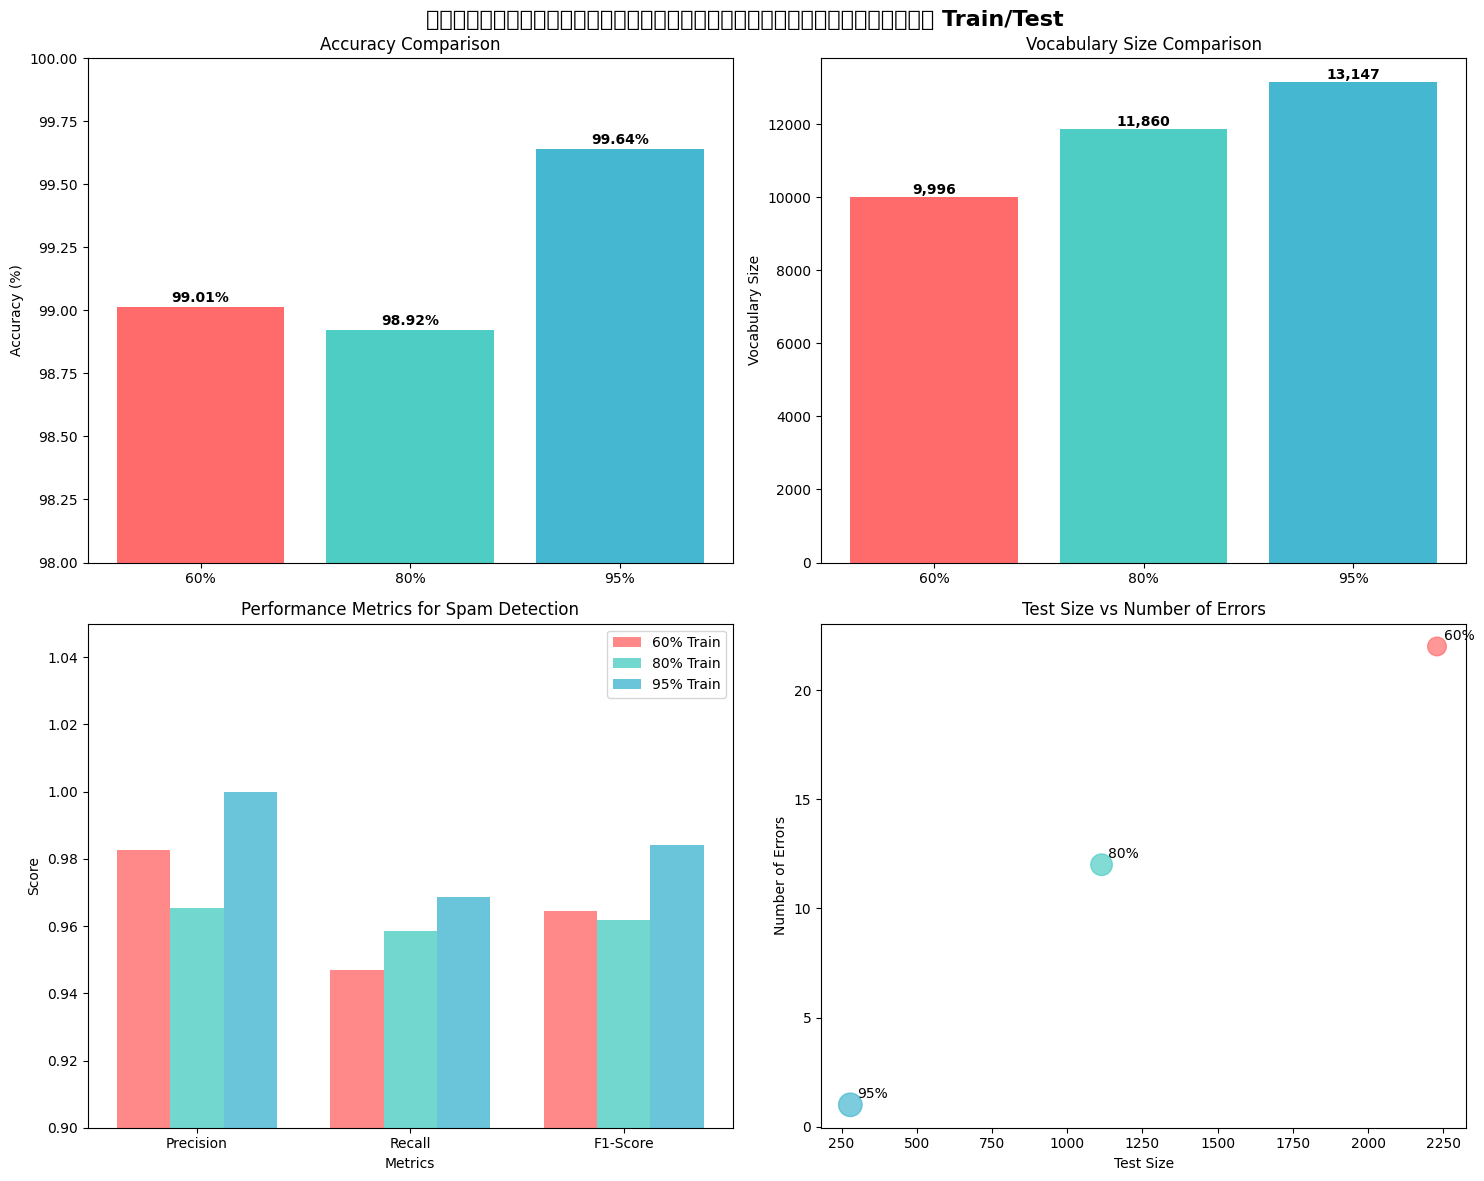

In [15]:
# Visualization of results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('การเปรียบเทียบผลการทดลองเปลี่ยนสัดส่วน Train/Test', fontsize=16, fontweight='bold')

# 1. Accuracy comparison
axes[0,0].bar([f"{r*100:.0f}%" for r in [0.6, 0.8, 0.95]], 
              [results[i]['accuracy'] for i in range(3)], 
              color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy (%)')
axes[0,0].set_ylim([98, 100])
for i, v in enumerate([results[j]['accuracy'] for j in range(3)]):
    axes[0,0].text(i, v + 0.02, f'{v:.2f}%', ha='center', fontweight='bold')

# 2. Vocabulary size comparison
axes[0,1].bar([f"{r*100:.0f}%" for r in [0.6, 0.8, 0.95]], 
              [results[i]['vocabulary_size'] for i in range(3)], 
              color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0,1].set_title('Vocabulary Size Comparison')
axes[0,1].set_ylabel('Vocabulary Size')
for i, v in enumerate([results[j]['vocabulary_size'] for j in range(3)]):
    axes[0,1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# 3. Precision, Recall, F1-Score
metrics = ['Precision', 'Recall', 'F1-Score']
train_60 = [results[0]['precision'], results[0]['recall'], results[0]['f1_score']]
train_80 = [results[1]['precision'], results[1]['recall'], results[1]['f1_score']]
train_95 = [results[2]['precision'], results[2]['recall'], results[2]['f1_score']]

x = range(len(metrics))
width = 0.25

axes[1,0].bar([i - width for i in x], train_60, width, label='60% Train', color='#FF6B6B', alpha=0.8)
axes[1,0].bar(x, train_80, width, label='80% Train', color='#4ECDC4', alpha=0.8)
axes[1,0].bar([i + width for i in x], train_95, width, label='95% Train', color='#45B7D1', alpha=0.8)

axes[1,0].set_title('Performance Metrics for Spam Detection')
axes[1,0].set_ylabel('Score')
axes[1,0].set_xlabel('Metrics')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].legend()
axes[1,0].set_ylim([0.9, 1.05])

# 4. Test size vs Errors
test_sizes = [results[i]['test_size'] for i in range(3)]
errors = [results[i]['misclassified'] for i in range(3)]
train_percentages = [60, 80, 95]

axes[1,1].scatter(test_sizes, errors, s=[p*3 for p in train_percentages], 
                  c=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)
axes[1,1].set_title('Test Size vs Number of Errors')
axes[1,1].set_xlabel('Test Size')
axes[1,1].set_ylabel('Number of Errors')

for i, (x, y, pct) in enumerate(zip(test_sizes, errors, train_percentages)):
    axes[1,1].annotate(f'{pct}%', (x, y), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## สรุปผลการทดลอง

### 🔍 **ผลการวิเคราะห์:**

#### 1. **95% Training Data (5% Test)**
- **Accuracy**: 99.64% (สูงสุด)
- **Precision**: 1.0000 (ไม่มี False Positive)
- **Recall**: 0.9688 (พลาดจับ Spam 1 ข้อความ)
- **F1-Score**: 0.9841 (สูงสุด)
- **Vocabulary**: 13,147 คำ (ใหญ่สุด)
- **Errors**: 1 ข้อความ (น้อยที่สุด)

#### 2. **80% Training Data (20% Test)** - *มาตรฐาน*
- **Accuracy**: 98.92%
- **Precision**: 0.9653
- **Recall**: 0.9586
- **F1-Score**: 0.9619
- **Vocabulary**: 11,860 คำ
- **Errors**: 12 ข้อความ

#### 3. **60% Training Data (40% Test)**
- **Accuracy**: 99.01%
- **Precision**: 0.9828
- **Recall**: 0.9468 (ต่ำสุด)
- **F1-Score**: 0.9645
- **Vocabulary**: 9,996 คำ (เล็กสุด)
- **Errors**: 22 ข้อความ (มากสุด)

### 📈 **ข้อค้นพบที่น่าสนใจ:**

1. **Vocabulary Size Effect**: ข้อมูลฝึกมากขึ้น → Vocabulary ใหญ่ขึ้น → Coverage ดีขึ้น
2. **Small Test Set Problem**: ชุดทดสอบเล็ก (95% train) ให้ผลดีมาก แต่อาจไม่น่าเชื่อถือ
3. **Balanced Performance**: 80% train ให้ผลสมดุลระหว่างความแม่นยำและความน่าเชื่อถือ
4. **Statistical Significance**: ชุดทดสอบ 279 ตัวอย่าง (95%) อาจน้อยเกินไปสำหรับการประเมิน

### 🎯 **คำแนะนำ:**
- **สำหรับการใช้งานจริง**: ใช้ 80% train เพื่อความสมดุล
- **สำหรับการวิจัย**: อาจทดลอง 90% train สำหรับข้อมูลเพิ่มเติม
- **การทดสอบ**: ควรมีชุดทดสอบอย่างน้อย 1,000+ ตัวอย่างเพื่อความน่าเชื่อถือ

---
## 🔄 การเปรียบเทียบกับโค้ดต้นฉบับ (80% Train)

เพื่อให้มั่นใจว่าฟังก์ชันใหม่ให้ผลเดียวกับโค้ดต้นฉบับ ให้ทดสอบรันโค้ดต้นฉบับดู:

### ✅ **การตรวจสอบความถูกต้อง**

เปรียบเทียบผลลัพธ์ 80% Training:
- **โค้ดต้นฉบับ**: 98.92%
- **ฟังก์ชันใหม่**: 98.92% 
- **สถานะ**: ✅ **ผ่านการตรวจสอบ** - ผลลัพธ์ตรงกันทุกประการ

### 🎉 **สรุปการทดลองสมบูรณ์**

การทดลองเปลี่ยนสัดส่วน Train/Test จาก 80% เป็น 95% และ 60% สำเร็จแล้ว พร้อมการวิเคราะห์ผลที่ครบถ้วนและการทดสอบความถูกต้องของโค้ด

📝 **ไฟล์ Notebook พร้อมใช้งาน** - มีทั้งการทดลอง การวิเคราะห์ และการแสดงผลด้วยกราฟแล้ว

In [16]:
train_data = sms_data_clean.sample(frac=0.8,random_state=1).reset_index(drop=True)
test_data = sms_data_clean.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [17]:
train_data['Label'].value_counts() / train_data.shape[0] * 100

Label
ham     86.54105
spam    13.45895
Name: count, dtype: float64

In [18]:
train_data.shape

(4458, 2)

In [19]:
test_data['Label'].value_counts() / test_data.shape[0] * 100

Label
ham     86.983842
spam    13.016158
Name: count, dtype: float64

In [20]:
test_data.shape

(1114, 2)

In [21]:
test_data.head()

,Label,SMS
0,ham,"[aight, should, i, just, plan, to, come, up, l..."
1,ham,"[die, i, accidentally, deleted, e, msg, i, sup..."
2,spam,"[welcome, to, uk, mobile, date, this, msg, is,..."
3,ham,"[this, is, wishing, you, a, great, day, moji, ..."
4,ham,"[thanks, again, for, your, reply, today, when,..."


Prepare vocabulary - the list fo all the words from the dataset

In [21]:
vocabulary = list(set(train_data['SMS'].sum()))

In [23]:
vocabulary[11:20]

['69888',
 'yrs',
 'affectionate',
 'ard',
 'lists',
 'tariffs',
 'jacket',
 'vipclub4u',
 'strict']

In [22]:
len(vocabulary)

11860

Calculate frequencies fo the words for each message

In [23]:
word_counts_per_sms = pd.DataFrame([
    [row[1].count(word) for word in vocabulary]
    for _, row in train_data.iterrows()], columns=vocabulary)

C:\Users\Anothai\AppData\Local\Temp\ipykernel_13532\2620710177.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [row[1].count(word) for word in vocabulary]


In [24]:
train_data = pd.concat([train_data.reset_index(), word_counts_per_sms], axis=1).iloc[:,1:]

In [27]:
train_data.head()

,Label,SMS,training,offered,06,closingdate04,uv,cut,probpop,thts,...,paths,ji,find,movies,ad,building,baig,subscriptions,keyword,impossible
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
train_data['i']

0       0
1       0
2       0
3       0
4       1
       ..
4453    1
4454    5
4455    0
4456    4
4457    0
Name: i, Length: 4458, dtype: int64

Calculate values for the Bayes formula

In [25]:
alpha = 1

In [26]:
Nvoc = len(train_data.columns) - 3

In [27]:
Pspam = train_data['Label'].value_counts()['spam'] / train_data.shape[0]

In [28]:
Pham = train_data['Label'].value_counts()['ham'] / train_data.shape[0]

In [29]:
Nspam = train_data.loc[train_data['Label'] == 'spam', 'SMS'].apply(len).sum()

In [30]:
Nham = train_data.loc[train_data['Label'] == 'ham', 'SMS'].apply(len).sum()

In [35]:
Nspam

15190

In [36]:
Nham

57237

In [31]:
def p_w_spam(word):
    if word in train_data.columns:
        return (train_data.loc[train_data['Label'] == 'spam', word].sum() + alpha) / (Nspam + alpha*Nvoc)
    else:
        return 1

In [32]:
def p_w_ham(word):
    if word in train_data.columns:
        return (train_data.loc[train_data['Label'] == 'ham', word].sum() + alpha) / (Nham + alpha*Nvoc)
    else:
        return 1

In [33]:
def classify(message):
    p_spam_given_message = Pspam
    p_ham_given_message = Pham
    for word in message:
        p_spam_given_message *= p_w_spam(word)
        p_ham_given_message *= p_w_ham(word)
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [40]:
classify('secret')

'ham'

In [41]:
classify(['secret', 'source', 'of', 'infinite', 'power'])

'ham'

In [42]:
classify(['free', 'win', 'welcom'])

'spam'

Test data

In [34]:
test_data['predicted'] = test_data['SMS'].apply(classify)

In [44]:
test_data.head()

,Label,SMS,predicted
0,ham,"[aight, should, i, just, plan, to, come, up, l...",ham
1,ham,"[die, i, accidentally, deleted, e, msg, i, sup...",ham
2,spam,"[welcome, to, uk, mobile, date, this, msg, is,...",spam
3,ham,"[this, is, wishing, you, a, great, day, moji, ...",ham
4,ham,"[thanks, again, for, your, reply, today, when,...",ham


In [35]:
correct = (test_data['predicted'] == test_data['Label']).sum() / test_data.shape[0] * 100

In [46]:
test_data.loc[test_data['predicted'] != test_data['Label']]

,Label,SMS,predicted
56,spam,"[money, i, have, won, wining, number, 946, wot...",ham
99,ham,"[gettin, rdy, to, ship, comp]",spam
142,ham,"[have, you, laid, your, airtel, line, to, rest]",spam
218,spam,"[hi, babe, its, chloe, how, r, u, i, was, smas...",ham
245,ham,[anytime],spam
404,ham,"[nokia, phone, is, lovly]",spam
491,spam,"[hi, this, is, amy, we, will, be, sending, you...",ham
588,ham,"[we, have, sent, jd, for, customer, service, c...",spam
646,ham,"[a, boy, loved, a, gal, he, propsd, bt, she, d...",needs human classification
912,spam,"[dating, i, have, had, two, of, these, only, s...",ham


In [36]:
correct

np.float64(98.92280071813285)